# Usporedba ljudskog, Edgarovog automatskog i LLM ocjenjivanja studentskih rješenja

## Uvod

Tema ovog projekta bavi se usporedbom triju pristupa ocjenjivanju studentskih radova; ljudskog, Edgarovog automatskog i onog temeljenog na velikim jezičnim modelima (LLM). Poseban naglasak stavlja se na potencijal LLM-a da kombinira prednosti ljudskog prosuđivanja i automatizirane obrade.  

Tradicionalno ljudsko ocjenjivanje studentskih radova omogućuje uvažavanje rješenja koja ne slijede standardne obrasce, jednostavno parcijalno bodovanje rješenja koja ne dovode do točnog rezultata, ali koriste djelomično točan postupak, te kaznu rješenja koja dolaze do točnog odgovora na nepoželjan način. Glavni nedostatci su velika vremenska zahtjevnost i potreba za većim brojem kvalificiranih ocjenjivača, kao i subjektivnost ocjenjivača, koja se može djelomično ublažiti postavljanjem kriterija ocjenjivanja.  

Automatsko ocjenjivanje omogućuje brzo i konzistentno ocjenjivanje, ali je često teško postići fleksibilnost koju pruža ljudski ocjenjivač.  

U okviru ovog projekta fokus je na ocjenjivanju jednostavnih studentskih programskih rješenja namijenjenih rješavanju specifičnih problema, konkretno zadataka s kolegija "Uvod u programiranje". Studentska rješenja trenutačno se provjeravaju automatski putem sustava Edgar, koji ispituje točnost izlaza za unaprijed definirane ulaze, te naknadno ljudskom provjerom kojom se procjenjuje i boduje rješenje.  

U posljednje vrijeme LLM-ovi postižu napredak u razumijevanju jezika i koda, što otvara mogućnost njihove primjene i u ocjenjivanju studentskih programskih rješenja.  

## Cilj projekta

Cilj projekta je provesti kvantitativnu i kvalitativnu usporednu analizu između ljudskog, automatskog i LLM pristupa ocjenjivanja studentskih programskih rješenja. U tu svrhu odabrana su dva LLM-a te su osmišljeni upiti koji će davati poželjne odgovore na studentska rješenja zadataka.  

___

# Učitavanje i početno čišćenje podataka

U ovoj sekciji učitavamo glavnu dataset datoteku `studentTestQuestion.csv`, 
koja sadrži podatke o automatskom (Edgar) i ručnom (manualnom) ocjenjivanju 
studentskih programskih rješenja.

Nakon učitavanja:
- pregledat ćemo strukturu podataka,
- provjeriti postoje li nedostajuće vrijednosti,
- provjeriti tipove podataka,
- izvršiti osnovno čišćenje (npr. provjera duplikata, micanje zapisa gdje nije bilo manualnog ispravljanja),
- pripremiti podatke za daljnju statističku analizu Edgar vs Manual ocjenjivanja.




In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Učitavanje CSV-a 
df = pd.read_csv("studentTestQuestion.csv", sep=';')

# 2) Pregled osnovnih informacija
print("Prvih 5 redova:")
display(df.head())

print("\nInformacije o stupcima:")
print(df.info())

print("\nOpisna statistika numeričkih stupaca:")
display(df.describe())

# 3) Provjera nedostajućih podataka
print("\nBroj nedostajućih vrijednosti po stupcu:")
display(df.isna().sum())

# 4) Uklanjanje potpuno praznih stupaca
empty_cols = df.columns[df.isna().all()]
if len(empty_cols) > 0:
    print("\nUklanjam prazne stupce:", list(empty_cols))
    df = df.drop(columns=empty_cols)

# 5) Uklanjanje duplikata (po cijelom retku)
dups = df.duplicated().sum()
print(f"\nBroj duplikata u tablici: {dups}")

if dups > 0:
    df = df.drop_duplicates()
    print("Duplikati uklonjeni.")

# 6) Provjera tipova stupaca – ako su brojčani zapisani kao string, probamo ih pretvoriti
numeric_cols = [
    'test_score_ed', 'test_score_man',
    'test_score_perc_ed', 'test_score_perc_man',
    'question_score_ed', 'question_score_man',
    'question_score_perc_ed', 'question_score_perc_man',
    'diff_perc'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nAžurirani tipovi podataka:")
print(df.dtypes)

# 7) Uklanjanje zapisa gdje MANUALNI score nije stvarno ocijenjen

# Pravilo:
#  - ako je question_score_man == 0  AND  id_app_user == 0 ili NaN,
#    tada pitanje nije ocijenio čovjek
condition_no_manual = (
    (df['question_score_man'] == 0) &
    ((df['id_app_user'] == 0) | (df['id_app_user'].isna()))
)

removed_count = condition_no_manual.sum()

print(f"\nBroj zapisa gdje nema stvarnog manualnog ocjenjivanja: {removed_count}")

# Uklanjamo te zapise
df = df[~condition_no_manual]

print("Zapisi bez ljudskog ocjenjivanja uklonjeni.")
print(f"Preostalo redova: {len(df)}")


# 8) Uklanjanje sumnjivih nultih manualnih ocjena
threshold = 0.5  # 50% max score

condition_suspicious_test = (
    (df['test_score_man'] == 0) &
    (df['test_score_ed'] >= threshold * df['test_max_score'])
)

suspicious_count = condition_suspicious_test.sum()
print(f"\nBroj sumnjivih zapisa (test_score_man=0 i test_score_ed >= 50% max): {suspicious_count}")

# Uklanjanje tih zapisa (samo ako želiš)
df = df[~condition_suspicious_test]

print(f"Preostalo redova nakon uklanjanja sumnjivih testova: {len(df)}")

print("Prvih 5 redova:")
display(df.head())


Prvih 5 redova:


,id_test,id_test_instance,id_academic_year,title,id_student,test_max_score,test_score_ed,test_score_man,test_score_perc_ed,test_score_perc_man,id_question,student_answer_code,id_app_user,question_score_ed,question_score_man,question_score_perc_ed,question_score_perc_man,diff_perc
0,14530,332559,2023,Završni ispit 2023/24 - drugi termin,10127,40.0,30.0,0.0,0.75,0.00,47999,\r\n\r\n\r\n\r\n#include <ctype.h>\r\n#include...,1176.0,10.0,0.0,1.0,0.0,1.0
1,14529,330776,2023,Završni ispit 2023/24 - prvi termin,8863,40.0,30.0,22.0,0.75,0.55,48002,"int k = 0;\r\n long long int polje[48] = {0, 1...",1030.0,10.0,0.0,1.0,0.0,1.0
2,14530,331780,2023,Završni ispit 2023/24 - drugi termin,9050,40.0,30.0,20.0,0.75,0.50,48011,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,1003.0,10.0,0.0,1.0,0.0,1.0
3,14530,332559,2023,Završni ispit 2023/24 - drugi termin,10127,40.0,30.0,0.0,0.75,0.00,48011,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,1176.0,10.0,0.0,1.0,0.0,1.0
4,14530,332559,2023,Završni ispit 2023/24 - drugi termin,10127,40.0,30.0,0.0,0.75,0.00,48019,\r\n\r\n\r\n\r\nint brojiDjelj3Kumulativno(int...,1176.0,10.0,0.0,1.0,0.0,1.0



Informacije o stupcima:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_test                  1000 non-null   int64  
 1   id_test_instance         1000 non-null   int64  
 2   id_academic_year         1000 non-null   int64  
 3   title                    1000 non-null   object 
 4   id_student               1000 non-null   int64  
 5   test_max_score           1000 non-null   float64
 6   test_score_ed            1000 non-null   float64
 7   test_score_man           1000 non-null   float64
 8   test_score_perc_ed       1000 non-null   float64
 9   test_score_perc_man      1000 non-null   float64
 10  id_question              1000 non-null   int64  
 11  student_answer_code      997 non-null    object 
 12  id_app_user              990 non-null    float64
 13  question_score_ed        1000 non-null   float64
 14  

,id_test,id_test_instance,id_academic_year,id_student,test_max_score,test_score_ed,test_score_man,test_score_perc_ed,test_score_perc_man,id_question,id_app_user,question_score_ed,question_score_man,question_score_perc_ed,question_score_perc_man,diff_perc
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,990.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,14675.432000,361048.924000,2023.32000,10065.443000,42.130000,25.076269,24.704775,0.605119,0.603329,48328.838000,1088.272727,8.587749,6.80745,0.809466,0.661710,0.147756
std,212.483304,42420.131809,0.46671,561.485894,10.132412,11.709072,11.148345,0.270172,0.265786,475.744394,154.565598,4.334566,4.15751,0.347818,0.377072,0.232851
min,14529.000000,330743.000000,2023.00000,8091.000000,30.000000,0.000000,0.000000,0.000000,0.000000,47999.000000,6.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,14530.000000,331852.250000,2023.00000,9705.500000,40.000000,17.500000,17.500000,0.438000,0.433000,47999.000000,1025.000000,7.500000,3.50000,0.750000,0.379250,0.000000
50%,14530.000000,332373.500000,2023.00000,9937.000000,40.000000,25.000000,25.500000,0.625000,0.625000,48005.000000,1135.000000,10.000000,8.00000,1.000000,0.850000,0.050000
75%,14923.000000,407221.250000,2024.00000,10570.250000,40.000000,32.500000,33.000000,0.813000,0.813000,48928.000000,1162.000000,10.000000,10.00000,1.000000,1.000000,0.200000
max,15017.000000,433976.000000,2024.00000,11145.000000,70.000000,70.000000,67.300000,1.000000,1.000000,49091.000000,1236.000000,18.000000,17.50000,1.000000,1.000000,1.000000



Broj nedostajućih vrijednosti po stupcu:


id_test                     0
id_test_instance            0
id_academic_year            0
title                       0
id_student                  0
test_max_score              0
test_score_ed               0
test_score_man              0
test_score_perc_ed          0
test_score_perc_man         0
id_question                 0
student_answer_code         3
id_app_user                10
question_score_ed           0
question_score_man          0
question_score_perc_ed      0
question_score_perc_man     0
diff_perc                   0
dtype: int64


Broj duplikata u tablici: 0

Ažurirani tipovi podataka:
id_test                      int64
id_test_instance             int64
id_academic_year             int64
title                       object
id_student                   int64
test_max_score             float64
test_score_ed              float64
test_score_man             float64
test_score_perc_ed         float64
test_score_perc_man        float64
id_question                  int64
student_answer_code         object
id_app_user                float64
question_score_ed          float64
question_score_man         float64
question_score_perc_ed     float64
question_score_perc_man    float64
diff_perc                  float64
dtype: object

Broj zapisa gdje nema stvarnog manualnog ocjenjivanja: 4
Zapisi bez ljudskog ocjenjivanja uklonjeni.
Preostalo redova: 996

Broj sumnjivih zapisa (test_score_man=0 i test_score_ed >= 50% max): 21
Preostalo redova nakon uklanjanja sumnjivih testova: 975
Prvih 5 redova:


,id_test,id_test_instance,id_academic_year,title,id_student,test_max_score,test_score_ed,test_score_man,test_score_perc_ed,test_score_perc_man,id_question,student_answer_code,id_app_user,question_score_ed,question_score_man,question_score_perc_ed,question_score_perc_man,diff_perc
1,14529,330776,2023,Završni ispit 2023/24 - prvi termin,8863,40.0,30.0,22.0,0.750,0.550,48002,"int k = 0;\r\n long long int polje[48] = {0, 1...",1030.0,10.0,0.0,1.0,0.0,1.0
2,14530,331780,2023,Završni ispit 2023/24 - drugi termin,9050,40.0,30.0,20.0,0.750,0.500,48011,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,1003.0,10.0,0.0,1.0,0.0,1.0
5,15017,433908,2024,Ispitni rok veljača 2024/25,10106,70.0,35.0,18.0,0.500,0.257,49047,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,1137.0,17.0,0.0,1.0,0.0,1.0
7,15017,433815,2024,Ispitni rok veljača 2024/25,10527,70.0,52.0,48.0,0.743,0.686,49047,#include <stdio.h>\r\nvoid posluziNapitak(shor...,1025.0,17.0,0.0,1.0,0.0,1.0
8,15017,433841,2024,Ispitni rok veljača 2024/25,10574,70.0,52.0,35.0,0.743,0.500,49047,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,1214.0,17.0,0.0,1.0,0.0,1.0


___

# Usporedba Edgarovog i manualnog ocjenjivanja

## 1) Osnovne metrike i usporedbe

Nakon početnog čišćenja podataka uklonili smo zapise kod kojih `question_score_man = 0.0`
i gdje je utvrđeno da zapravo nije provedeno ručno ocjenjivanje. Preostalo je cca 1000
valjanih zapisa, koji predstavljaju rješenja studenata za koja imamo i Edgarovu
i ručnu evaluaciju.

U ovoj sekciji provest ćemo osnovnu usporedbu Edgarovog (`question_score_ed`)
i manualnog ocjenjivanja (`question_score_man`). Ciljevi analize:

- izračunati distribuciju razlika u bodovanju,
- vizualizirati odnos između dvaju pristupa,
- provjeriti postoji li sustavno precjenjivanje ili podcjenjivanje,
- pripremiti podatke za kasniju statističku analizu.

U nastavku slijedi kod kojim izračunavamo osnovne metrike i crtamo grafičke prikaze.


Osnovna statistika razlika (manual - edgar):


count    975.000000
mean      -1.565435
std        2.881971
min      -17.000000
25%       -2.000000
50%       -0.500000
75%        0.000000
max        0.000000
Name: score_diff, dtype: float64

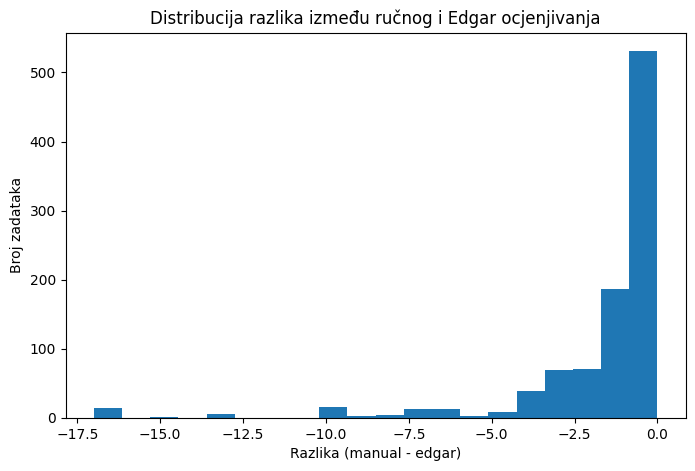

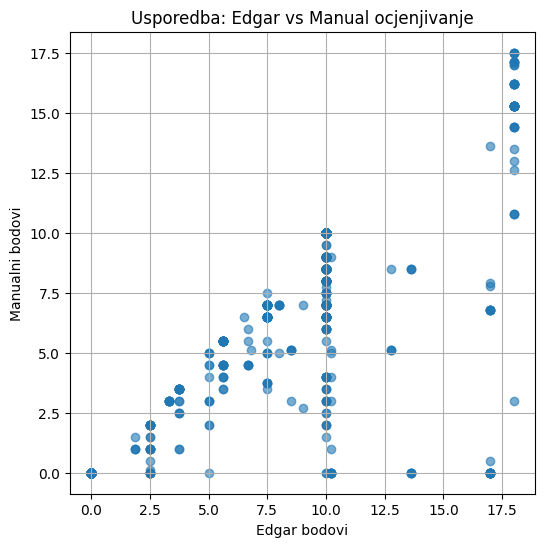

Korelacija između Edgar i manualnog ocjenjivanja: 0.764


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Izračun razlike između manualnog i Edgar ocjenjivanja
df['score_diff'] = df['question_score_man'] - df['question_score_ed']

print("Osnovna statistika razlika (manual - edgar):")
display(df['score_diff'].describe())

# 2) Histogram distribucije razlika
plt.figure(figsize=(8,5))
plt.hist(df['score_diff'], bins=20)
plt.xlabel("Razlika (manual - edgar)")
plt.ylabel("Broj zadataka")
plt.title("Distribucija razlika između ručnog i Edgar ocjenjivanja")
plt.show()

# 3) Scatter plot Edgar vs Manual
plt.figure(figsize=(6,6))
plt.scatter(df['question_score_ed'], df['question_score_man'], alpha=0.6)
plt.xlabel("Edgar bodovi")
plt.ylabel("Manualni bodovi")
plt.title("Usporedba: Edgar vs Manual ocjenjivanje")
plt.grid(True)
plt.show()

# 4) Korelacija
corr = df[['question_score_ed','question_score_man']].corr().iloc[0,1]
print(f"Korelacija između Edgar i manualnog ocjenjivanja: {corr:.3f}")


### Interpretacija osnovne usporedbe Edgar vs Manualno

Analiza razlika između manualnog i Edgar ocjenjivanja pokazuje sljedeće:

- **Broj zapisa:** 975 nakon čišćenja sumnjivih testova.  
- **Prosječna razlika (manual - Edgar):** -1.57 bodova, što znači da je Edgar u prosjeku blago **blaži** od ljudskog ocjenjivanja.  
- **Raspon razlika:** od -17 do 0 bodova. Većina zadataka ima male razlike (25% ≤ -2, 50% ≤ -0.5, 75% = 0).  
- **Histogram:** većina razlika se nalazi blizu nule, što potvrđuje da je općenito velika podudarnost između Edgarovih i manualnih ocjena.  
- **Scatter plot:** većina točaka je ispod linije x = y, što znači da su Edgarove ocjene u prosjeku više od manualnih, ali postoje i rijetki slučajevi značajnijih razlika (donji dio trokuta).  

**Zaključak:** Edgar je konzistentan i u većini slučajeva daje slične bodove kao ljudski ocjenjivači, s tendencijom blago **blažeg** bodovanja. 


## 2) Korelacijska analiza: Pearson i Spearman

Pearson mjeri **linearni odnos** između dviju varijabli.  
Dobra je ako pretpostavljamo da su promjene u Edgarovom rezultatu proporcionalno povezane s manualnim rezultatom.

Međutim, Pearson je osjetljiv na:
- nelinearne odnose  
- outliere  
- nejednake raspodjele bodova  
- diskretne ili saturirane podatke (npr. puno nula ili puno maksimalnih bodova)

Zato ga koristimo kao dopunu, ali ne kao jedini pokazatelj.

Spearman mjeri **rang korelaciju** — gleda poredak, a ne stvarne vrijednosti.

Zašto je Spearman dobar za ovaj slučaj?
- podaci imaju puno ekstremnih vrijednosti (0, max)  
- distribucija nije normalna  
- mogući su nelinearni odnosi  
- različiti ispravljači i zadaci utječu na skalu bodovanja  

U nastavku izračunavamo i Pearson i Spearman koeficijent
za ukupne rezultate testa: `test_score_ed` i `test_score_man`.



In [7]:
from scipy.stats import pearsonr, spearmanr

# 1) Pearson
pearson_corr, pearson_p = pearsonr(df["test_score_ed"], df["test_score_man"])

# 2) Spearman
spearman_corr, spearman_p = spearmanr(df["test_score_ed"], df["test_score_man"])

print("Pearson korelacija")
print(f"Koeficijent: {pearson_corr:.4f}")
print(f"P-vrijednost: {pearson_p:.4e}")

print("\nSpearman korelacija")
print(f"Koeficijent: {spearman_corr:.4f}")
print(f"P-vrijednost: {spearman_p:.4e}")


Pearson korelacija
Koeficijent: 0.9192
P-vrijednost: 0.0000e+00

Spearman korelacija
Koeficijent: 0.9221
P-vrijednost: 0.0000e+00


### Interpretacija korelacijske analize

Dobiveni Pearsonov (0.919) i Spearmanov koeficijent (0.922) pokazuju **vrlo visoko slaganje** između Edgarovih i manualnih ocjena. Oba testa ukazuju da Edgar i ljudski ocjenjivači daju ocjene koje su međusobno snažno linearno i rang-povezane. Spearmanov koeficijent, koji je robusniji na nelinearnosti i outliere, potvrđuje da je i relativno rangiranje studenata gotovo identično u oba sustava. Ovo znači da Edgar u velikoj većini slučajeva ocjenjuje studente na način koji je vrlo blizak ljudskom ocjenjivanju.


## 3) Jednostavna linearna regresija između Edgar i manualnih ocjena

Linearni regresijski model koristi se kako bi se kvantitativno ispitalo koliko dobro manualne ocjene mogu biti objašnjene Edgarovim ocjenama.

Nakon regresije interpretirat ćemo nagib, presjek i R² kako bismo vidjeli u kojoj mjeri Edgar replicira ponašanje ljudskog ispitivača.



Slope (nagib): 0.8503
Intercept (presjek): 4.2215
R-squared: 0.8449
P-vrijednost: 0.0000e+00
Standard error: 0.0117


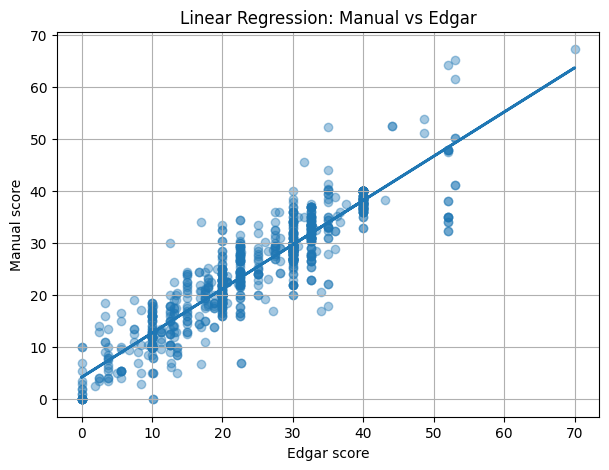

In [9]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

# X = Edgar, Y = Manual
X = df["test_score_ed"]
Y = df["test_score_man"]

# Linearna regresija
reg = linregress(X, Y)

print(f"Slope (nagib): {reg.slope:.4f}")
print(f"Intercept (presjek): {reg.intercept:.4f}")
print(f"R-squared: {reg.rvalue**2:.4f}")
print(f"P-vrijednost: {reg.pvalue:.4e}")
print(f"Standard error: {reg.stderr:.4f}")

# Scatter + regresijska linija
plt.figure(figsize=(7,5))
plt.scatter(X, Y, alpha=0.4)
plt.plot(X, reg.intercept + reg.slope * X, linewidth=2)
plt.xlabel("Edgar score")
plt.ylabel("Manual score")
plt.title("Linear Regression: Manual vs Edgar")
plt.grid(True)
plt.show()


### Interpretacija linearne regresije

- **Nagib (slope) = 0.85**  
  Kada Edgar poveća ocjenu za 1 bod, manualna ocjena raste u prosjeku za samo 0.85 bodova. To znači da je Edgar **blaži** — daje nešto više bodova od ljudi.

- **R² = 0.8449**  
  Oko **84% varijance** manualnih ocjena objašnjeno je Edgarovim ocjenama → vrlo dobra podudarnost.

- **P-vrijednost ≈ 0**  
  Povezanost je statistički značajna.

**Zaključak:** Linearna regresija potvrđuje snažnu povezanost manualnih i Edgarovih ocjena, uz blagu i konzistentnu tendenciju Edgarovog blažeg ocjenjivanja.


## 4) Analiza outliera (neuobičajenih razlika u ocjenjivanju)

U ovoj sekciji identificiramo zadatke kod kojih je razlika između manualnog i Edgarovog ocjenjivanja izrazito velika u odnosu na ostatak distribucije. Outlieri su važni jer:

- mogu ukazati na **problematične zadatke**,
- mogu otkriti slučajeve gdje se Edgar i ljudski ocjenjivači **snažno razilaze**,
- pomažu u procjeni stabilnosti sustava i razumijevanju potencijalnih slabih točaka.

Koristit ćemo **IQR metoda** (standardna detekcija outliera)



In [11]:
Q1 = df['score_diff'].quantile(0.25)
Q3 = df['score_diff'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['score_diff'] < lower_bound) | (df['score_diff'] > upper_bound)]

print(f"Broj detektiranih outliera: {len(outliers)}")

# Pogled prvih nekoliko
outliers[['test_score_man', 'test_score_ed', 'score_diff']].head(10)


Broj detektiranih outliera: 75


,test_score_man,test_score_ed,score_diff
1,22.0,30.0,-10.0
2,20.0,30.0,-10.0
5,18.0,35.0,-17.0
7,48.0,52.0,-17.0
8,35.0,52.0,-17.0
9,32.3,52.0,-17.0
10,30.3,26.0,-17.0
11,17.0,34.0,-17.0
12,20.6,34.0,-17.0
13,38.3,43.0,-17.0


### Interpretacija analize outliera

U analizi je detektirano **75 outliera**, a svi imaju značajno **negativne vrijednosti razlike** (manual – Edgar < 0). To znači da je u tim slučajevima Edgar dodijelio **bitno više bodova** nego ljudski ocjenjivač.

Ove razlike su velike — od **–10 do –17 bodova**, što ih čini izrazitim odstupanjima od uobičajenih razlika koje se kreću oko nule. To sugerira da postoji **specifična skupina zadataka ili odgovora** gdje Edgar sustavno precjenjuje učenike.
